In [1]:
## SECTION 0. Library imports.
import mysql.connector
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from scipy import stats
from IPython.display import HTML
%matplotlib inline

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
## SECTION 1. Phone processing routes and total process times.
## Step 1. Read the server credentials from the settings file.
file_path = os.path.join(os.getcwd(), 'Settings')
with open(os.path.join(file_path,'settingsSQL.txt'), 'r') as settings_file:
    content = settings_file.readlines()
content = [item.strip().split(' = ')[1] for item in content]
## Step 2. Connection to the database.
conn = mysql.connector.connect(host = content[0],
                               user = content[1],
                               password = content[2],
                               db= content[3])
cursor = conn.cursor()
## Step 3. Query the database for the visual inspection grades for phones.
cursor.execute(r"SELECT product.idproduct, product.br_number_idbr_number, product.manufacturer_idmanufacturer, \
                product.model_idmodel, product.processType, product.sold_to, product.finished_processing, \
                product_type.type, \
                process_history.idprocess, process_history.start_time, process_history.end_time, process_history.station_idstation, \
                process_history.process_types_idprocess_types FROM product \
                INNER JOIN product_type ON product.product_type_idproduct_type = product_type.idproduct_type \
                INNER JOIN process_history ON product.idproduct = process_history.product_idproduct \
                WHERE product_type.type = 'mobile phone';")
rows = cursor.fetchall()
connection_closed = cursor.close()

In [4]:
## Step 4. Construct a dataframe with the results.
column_names = ['idproduct', 'br_number_idbr_number', 'manufacturer_idmanufacturer', 'model_idmodel', 
               'processType', 'sold_to', 'finished_processing', 'type', 'idprocess', 'start_time',
               'end_time', 'station_idstation', 'process_types_idprocess_types']
raw_data_frame = pd.DataFrame(list(rows), columns = column_names)
## Step 5. Rename remaining columns.
raw_data_frame.rename(columns={'idproduct':'id_product','br_number_idbr_number':'batch_number', 'manufacturer_idmanufacturer':'manufacturer_id',
                            'model_idmodel':'model_id', 'processType':'process_type_path', 'sold_to':'sold_to',
                            'finished_processing':'finish_processing',
                            'type':'product_type','idprocess':'process_id', 'start_time':'start_time', 'end_time':'end_time',
                            'station_idstation':'station_id', 'process_types_idprocess_types':'process_type'},
                   inplace = True)

In [5]:
## Step 6. Replace NaT value with end_time
idx = list(map(lambda x:not isinstance(x, pd._libs.tslib.Timestamp), raw_data_frame['start_time']))
raw_data_frame.loc[idx, 'start_time'] = raw_data_frame.loc[idx, 'end_time']

In [6]:
## Step 7. Change the start time to time format and set as the index for the dataframe.
raw_data_frame['start_time'] = pd.to_datetime(raw_data_frame['start_time'])
raw_data_frame.set_index(raw_data_frame['start_time'], drop=True, inplace=True)

In [7]:
def processing_times(time_process_data_frame):
    """
    This function gets the process time for both each operation and the total processing time in minutes.

    Parameters
    ----------
    time_process_data_frame : Dataframe
        The operation and start times for each operation.

    Returns
    -------
    result_dictionary : Dictionary
        Dictionary with the operation label and the processing time.
        
    CAUTION
    -------
    Duplicate entries must be removed before calling this function.
    """
    ## Step 1. Add a column with the shifted data and calculate the processing times.
    time_process_data_frame['end_time'] = time_process_data_frame['start_time'].shift(periods=-1)
    time_process_data_frame['diff'] = time_process_data_frame['end_time'] - time_process_data_frame['start_time']
    ## Step 2. Correct for the last process.
    time_process_data_frame['diff'] = list(map(lambda x:round(x.total_seconds() / 60, 2), time_process_data_frame['diff']))
    time_process_data_frame.loc[time_process_data_frame.index[-1], 'diff'] = sum(time_process_data_frame['diff'].dropna().values)    
    return {'process_route':time_process_data_frame['process_type'], 'diff':time_process_data_frame['diff']}  

In [8]:
## Step 8. Processing times for finished phones. Duplicate entries are removed here before calculating the process
## times.
processing_times_finalised = raw_data_frame.copy()
processing_times_finalised = processing_times_finalised[processing_times_finalised['finish_processing'] == 1]
processing_times_finalised.drop_duplicates(subset=['id_product', 'process_type'], keep='first', inplace=True)
processing_times_finalised = processing_times_finalised.groupby(by='id_product')[['process_type', 'start_time']].apply(func=processing_times)

In [9]:
## Step 9. Routes counts.
routes_and_times = pd.DataFrame({'routes':list(x['process_route'].values for x in processing_times_finalised),
                                'times':list(x['diff'].values for x in processing_times_finalised)})
routes_and_times['route_id'] = routes_and_times['routes'].apply(lambda x:str(x))
route_count = routes_and_times.groupby('route_id').count()
route_count.drop('routes', axis=1, inplace=True)
total_count = np.sum(route_count['times'])
route_count['times_ratio'] = route_count['times'] * 1.0 / total_count

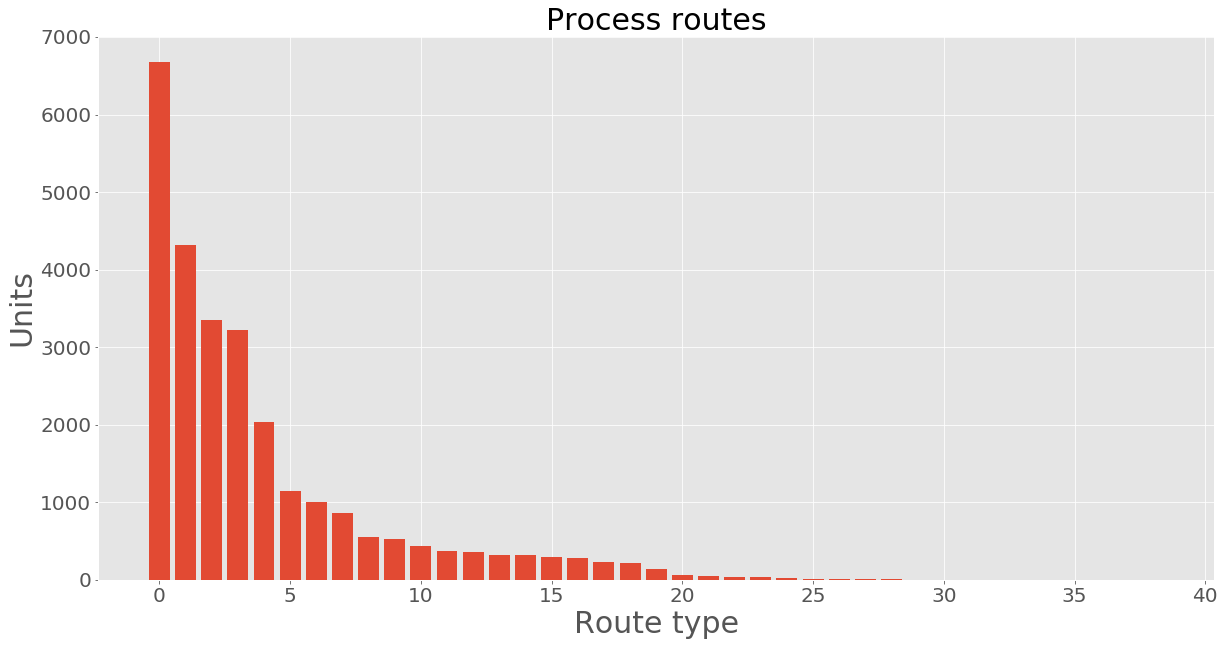

In [10]:
## Step 10. Route count barplot.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')
plt.xticks(size=20)
plt.yticks(size=20)
plot_data_frame = route_count.copy()
plot_data_frame.sort_values(by='times', axis=0, ascending=False, inplace=True)
plot_data_frame['graph_id'] = range(len(plot_data_frame))
plt.bar(left=np.arange(len(plot_data_frame.index)), height=plot_data_frame['times'])
plt.title('Process routes', fontsize=30)
plt.xlabel('Route type', fontsize=30)
plt.ylabel('Units', fontsize=30)

In [11]:
plot_data_frame

,times,times_ratio,graph_id
route_id,,,
[ 1 2 10],6676,0.248059,0
[ 1 2 5 4 10],4315,0.160331,1
[ 1 5 2 4 6 10],3353,0.124587,2
[ 1 5 2 4 10],3220,0.119645,3
[1 2],2032,0.075503,4
[1 5 2 8],1139,0.042322,5
[1 5 2 4 7 8],1005,0.037343,6
[ 1 5 2 4 7 6 10],864,0.032103,7
[ 1 2 4 5 10],547,0.020325,8


In [12]:
## Step 11. Total processing times.
idx = list(map(lambda x:'10' in x, routes_and_times['route_id']))
times_processing_sold = routes_and_times.loc[idx]

In [13]:
def total_processing_times_results(time_processes_data_frame):
    """
    This function gets the total process times for each route.
    Results are presented in days.

    Parameters
    ----------
    time_processes_data_frame : Dataframe
        The operation and start times for each operation and route.

    Returns
    -------
    result_dictionary : Dictionary
        Dictionary with the route and the processing times statistics.
        
    CAUTION
    -------
    Duplicate entries must be removed before calling this function.
    """
    ## Step 1. Retrieve the last value from the time process series.
    time_processes_data_frame['total_time'] = time_processes_data_frame['times'].apply(lambda x:x[-1])       
    ## Step 2. Calculate the statistics for the total time.
    minutes_to_days_factor = (1 / (60 * 24))
    mean_value_days = round(np.mean(time_processes_data_frame['total_time']) * minutes_to_days_factor, 2)
    std_value_days = round(np.std(time_processes_data_frame['total_time']) * minutes_to_days_factor, 2)
    first_quantile_value_days = round(np.percentile(time_processes_data_frame['total_time'], q=0.25) * minutes_to_days_factor, 2)
    median_quantile_value_days = round(np.percentile(time_processes_data_frame['total_time'], q=0.5) * minutes_to_days_factor, 2)
    third_quantile_value_days = round(np.percentile(time_processes_data_frame['total_time'], q=0.75) * minutes_to_days_factor, 2)
    max_value_days = round(np.max(time_processes_data_frame['total_time']) * minutes_to_days_factor, 2)
    min_value_days = round(np.min(time_processes_data_frame['total_time']) * minutes_to_days_factor, 2)
    sample_number = time_processes_data_frame.shape[0]
    return {'process_route':(time_processes_data_frame['route_id']).values[0], 'mean_value_days':mean_value_days,
           'std_value_days':std_value_days, 'first_quantile_value_days':first_quantile_value_days,
           'median_quantile_value_days':median_quantile_value_days, 'third_quantile_value_days':third_quantile_value_days,
           'max_value_days':max_value_days, 'min_value_days':min_value_days,
           'raw_values':time_processes_data_frame['total_time'].values * minutes_to_days_factor,
           'sample_number':sample_number}  


In [14]:
## Step 12. Total processing time statistics.
total_times_sold_distributions = times_processing_sold.groupby(by='route_id')[['times', 'route_id']].apply(total_processing_times_results)

In [15]:
## Step 13. Plot dataframe.
route_total_times = list()
route_id = list()
route_identifier = 0
for route in total_times_sold_distributions:
    route_total_times.extend(route['raw_values'])
    route_id.extend([route_identifier]*len(route['raw_values']))
    route_identifier += 1
plot_data_frame = pd.DataFrame({'route_id':route_id, 'route_total_times':route_total_times})
plot_data_frame['route_total_times'] = plot_data_frame['route_total_times'].astype(float)

In [16]:
## Step 14. Bokeh box plot.
from bokeh.charts import BoxPlot
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [17]:
total_times_sold_box_plot = BoxPlot(data=plot_data_frame, values='route_total_times', label='route_id', width = 700,
                                   height=700, legend=False, tools='pan,box_zoom,wheel_zoom,save,reset,help')
total_times_sold_box_plot.title.text = 'Total processing times mobile phones sold'
total_times_sold_box_plot.title.align = 'center'
total_times_sold_box_plot.title.text_font_size = '20pt'
total_times_sold_box_plot.yaxis.axis_label = 'Processing times (days)'
total_times_sold_box_plot.yaxis.axis_label_text_font_size = '20pt'
total_times_sold_box_plot.xaxis.axis_label = 'Route id'
total_times_sold_box_plot.xaxis.axis_label_text_font_size = '20pt'
total_times_sold_box_plot.yaxis.major_label_text_font_size = '16pt'
total_times_sold_box_plot.xaxis.major_label_text_font_size = '16pt'

In [18]:
show(total_times_sold_box_plot)

/Users/heinzlugo/anaconda/envs/python36/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [19]:
total_times_sold_distributions

route_id
[ 1  2  4  5 10]             {'process_route': '[ 1  2  4  5 10]', 'mean_va...
[ 1  2  4 10]                {'process_route': '[ 1  2  4 10]', 'mean_value...
[ 1  2  5  4 10]             {'process_route': '[ 1  2  5  4 10]', 'mean_va...
[ 1  2  5 10]                {'process_route': '[ 1  2  5 10]', 'mean_value...
[ 1  2 10]                   {'process_route': '[ 1  2 10]', 'mean_value_da...
[ 1  4  2  5 10]             {'process_route': '[ 1  4  2  5 10]', 'mean_va...
[ 1  4  2 10]                {'process_route': '[ 1  4  2 10]', 'mean_value...
[ 1  4  5  2 10]             {'process_route': '[ 1  4  5  2 10]', 'mean_va...
[ 1  5  2  4  6 10]          {'process_route': '[ 1  5  2  4  6 10]', 'mean...
[ 1  5  2  4  7  6 10]       {'process_route': '[ 1  5  2  4  7  6 10]', 'm...
[ 1  5  2  4  7  9  6 10]    {'process_route': '[ 1  5  2  4  7  9  6 10]',...
[ 1  5  2  4 10  6]          {'process_route': '[ 1  5  2  4 10  6]', 'mean...
[ 1  5  2  4 10  7  6]       {'process_rout

In [20]:
## Step 15. Split between processing times for mobile phones that have actually been sold and those who have finished
## processing.
idx = list(map(lambda x:'10' not in x, routes_and_times['route_id']))
times_processing_not_sold = routes_and_times.loc[idx]
total_times_not_sold_distributions = times_processing_not_sold.groupby(by='route_id')[['times', 'route_id']].apply(total_processing_times_results)

In [21]:
route_total_times = list()
route_id = list()
route_identifier = 0
for route in total_times_not_sold_distributions:
    route_total_times.extend(route['raw_values'])
    route_id.extend([route_identifier]*len(route['raw_values']))
    route_identifier += 1
plot_data_frame = pd.DataFrame({'route_id':route_id, 'route_total_times':route_total_times})
plot_data_frame['route_total_times'] = plot_data_frame['route_total_times'].astype(float)

In [22]:
total_times_not_sold_box_plot = BoxPlot(data=plot_data_frame, values='route_total_times', label='route_id', width = 700,
                                   height=700, legend=False, tools='pan,box_zoom,wheel_zoom,save,reset,help')
total_times_not_sold_box_plot.title.text = 'Total processing times mobile phones finished'
total_times_not_sold_box_plot.title.align = 'center'
total_times_not_sold_box_plot.title.text_font_size = '20pt'
total_times_not_sold_box_plot.yaxis.axis_label = 'Processing times (days)'
total_times_not_sold_box_plot.yaxis.axis_label_text_font_size = '20pt'
total_times_not_sold_box_plot.xaxis.axis_label = 'Route id'
total_times_not_sold_box_plot.xaxis.axis_label_text_font_size = '20pt'
total_times_not_sold_box_plot.yaxis.major_label_text_font_size = '16pt'
total_times_not_sold_box_plot.xaxis.major_label_text_font_size = '16pt'

In [23]:
show(total_times_not_sold_box_plot)

In [24]:
total_times_not_sold_distributions

route_id
[1 2 4 5]          {'process_route': '[1 2 4 5]', 'mean_value_day...
[1 2 4]            {'process_route': '[1 2 4]', 'mean_value_days'...
[1 2 5 4]          {'process_route': '[1 2 5 4]', 'mean_value_day...
[1 2]              {'process_route': '[1 2]', 'mean_value_days': ...
[1 4 2 5]          {'process_route': '[1 4 2 5]', 'mean_value_day...
[1 4 5 2]          {'process_route': '[1 4 5 2]', 'mean_value_day...
[1 5 2 4 6]        {'process_route': '[1 5 2 4 6]', 'mean_value_d...
[1 5 2 4 7 6]      {'process_route': '[1 5 2 4 7 6]', 'mean_value...
[1 5 2 4 7 8]      {'process_route': '[1 5 2 4 7 8]', 'mean_value...
[1 5 2 4 7 9 8]    {'process_route': '[1 5 2 4 7 9 8]', 'mean_val...
[1 5 2 4 8]        {'process_route': '[1 5 2 4 8]', 'mean_value_d...
[1 5 2 4]          {'process_route': '[1 5 2 4]', 'mean_value_day...
[1 5 2 7 4 6]      {'process_route': '[1 5 2 7 4 6]', 'mean_value...
[1 5 2 7 8]        {'process_route': '[1 5 2 7 8]', 'mean_value_d...
[1 5 2 8]          {'proc

In [25]:
## Step 16. Grouped plot for sold and finished process mobile phones.
from bokeh.plotting import figure
mean_value_days = list()
std_value_days = list()
sample_number = list()
colour_sold = list()
legend_sold = list()
process_route = list()
for route in total_times_sold_distributions:
    mean_value_days.append(route['mean_value_days'])
    std_value_days.append(route['std_value_days'])
    sample_number.append(route['sample_number'])
    process_route.append(route['process_route'])
    colour_sold.append('green')
    legend_sold.append('sold')
for route in total_times_not_sold_distributions:
    mean_value_days.append(route['mean_value_days'])
    std_value_days.append(route['std_value_days'])
    sample_number.append(route['sample_number'])
    process_route.append(route['process_route'])
    colour_sold.append('orange')
    legend_sold.append('processed')
plot_data_frame = pd.DataFrame({'mean_value_days':mean_value_days, 'std_value_days':std_value_days,
                               'sample_number':sample_number, 'process_route':process_route,
                               'colour_sold':colour_sold, 'legend_sold':legend_sold})

In [26]:
## Step 16.1. Scatter plot for sold and finished process mobile phones.
source_data = ColumnDataSource(data=dict(x=plot_data_frame['mean_value_days'],
                                       y=plot_data_frame['sample_number'],
                                       fill_color=plot_data_frame['colour_sold'],
                                       std_value_days=plot_data_frame['std_value_days'],
                                       legend_sold=plot_data_frame['legend_sold'],
                                       sample_number=plot_data_frame['sample_number'],
                                       process_route=plot_data_frame['process_route']
                                       ))
hover_info = HoverTool(tooltips=[
    ('Route','@process_route'),
    ('Mean','@x{1.11}'),
    ('Std','@std_value_days{1.11}'),
    ('Occurrences', '@sample_number')
])
total_times_phones_figure = figure(plot_height=700, plot_width=700, title="Total processing times",
                           tools='pan,box_zoom,wheel_zoom,save,reset,help',
                           x_axis_label='Mean processing time (days)',
                           y_axis_label='Occurrences')
total_times_phones_figure.circle(source=source_data, x='x',y='y',fill_color='fill_color', size = 10,
                                line_color=None,legend='legend_sold')
total_times_phones_figure.add_tools(hover_info)
total_times_phones_figure.title.align = 'center'
total_times_phones_figure.title.text_font_size = '20pt'
total_times_phones_figure.yaxis.axis_label_text_font_size = '20pt'
total_times_phones_figure.xaxis.axis_label_text_font_size = '20pt'
total_times_phones_figure.yaxis.major_label_text_font_size = '16pt'
total_times_phones_figure.xaxis.major_label_text_font_size = '16pt'
show(total_times_phones_figure)


In [27]:
plot_data_frame

,colour_sold,legend_sold,mean_value_days,process_route,sample_number,std_value_days
0,green,sold,29.58,[ 1 2 4 5 10],547,25.75
1,green,sold,44.75,[ 1 2 4 10],4,31.78
2,green,sold,31.29,[ 1 2 5 4 10],4315,26.40
3,green,sold,52.00,[ 1 2 5 10],3,4.89
4,green,sold,9.87,[ 1 2 10],6676,15.77
5,green,sold,25.12,[ 1 4 2 5 10],530,22.20
6,green,sold,7.32,[ 1 4 2 10],11,7.58
7,green,sold,34.00,[ 1 4 5 2 10],354,32.65
8,green,sold,18.90,[ 1 5 2 4 6 10],3353,20.93
9,green,sold,14.14,[ 1 5 2 4 7 6 10],864,11.49


In [28]:
## SECTION 2. Phone processing routes and total process times.

In [29]:
from itertools import tee
def pairwise(iterable):
    """
    This function creates tuple pairs from the iterable array passed as argument.

    Parameters
    ----------
    iterable : Array
        Iterable from which the tuples will be built.

    Returns
    -------
    result_dictionary : List
        List with tuple pairs.
        
    CAUTION
    -------
    """
    a,b = tee(iterable)
    next(b, None)
    return list(zip(a,b))

In [30]:
def step_processing_times_results(time_processes_data_frame):
    """
    This function gets the step process times for each route.
    Results are presented in days.

    Parameters
    ----------
    time_processes_data_frame : Dataframe
        The operation and start times for each operation and route.

    Returns
    -------
    result_dictionary : Dictionary
        Dictionary with the route and the processing times statistics.
        
    CAUTION
    -------
    This function should be used with grouped by series or with series with a single route type.
    """
    ## Step 1. Generate the tuples pairs.
    tuples_pairs = pairwise(time_processes_data_frame.iloc[0]['routes'])
    ## Step 2. Gather times for each tuple pairs.
    time_per_route_n_array = list(x[:-1] for x in time_processes_data_frame['times'])
    time_per_route_data_frame = pd.DataFrame(data=time_per_route_n_array, columns=tuples_pairs)
    ## Step 3. Calculate the statistics for the step times.
    minutes_to_days_factor = (1 / (60 * 24))
    time_per_route_statistics = time_per_route_data_frame.describe()
    time_per_route_statistics = time_per_route_statistics.applymap(lambda x: x * minutes_to_days_factor)
    time_per_route_statistics.loc['count'] = time_per_route_statistics.loc['count'].values / minutes_to_days_factor
    ## Step 4. Convert the results to a dictionary to accomodate group by call.
    return {'process_start_stop':time_per_route_statistics.columns.values, 'mean_value_days':time_per_route_statistics.loc['mean'].values,
           'std_value_days':time_per_route_statistics.loc['std'].values, 'first_quantile_value_days':time_per_route_statistics.loc['25%'].values,
           'median_quantile_value_days':time_per_route_statistics.loc['50%'].values, 'third_quantile_value_days':time_per_route_statistics.loc['75%'].values,
           'max_value_days':time_per_route_statistics.loc['max'].values, 'min_value_days':time_per_route_statistics.loc['min'].values,
           'sample_number':time_per_route_statistics.loc['count'].values}  

In [31]:
## Step 1. Processing step times for sold and not sold products.
step_processing_times_sold_distributions = times_processing_sold.groupby(by='route_id')[['routes', 'times']].apply(step_processing_times_results)
step_processing_times_not_sold_distributions = times_processing_not_sold.groupby(by='route_id')[['routes', 'times']].apply(step_processing_times_results)

In [32]:
## Step 2. Plot dataframe
median_value_days = list()
mean_value_days = list()
std_value_days = list()
sample_number = list()
process_start_stop = list()
route_id = list()
stack_dummy_variable = list()
step_processing_times_sold_distributions_indexes = step_processing_times_sold_distributions.index.values
id_indexes = 0
indexes_step_processing_times_sold = step_processing_times_sold_distributions.index.values
indexes_step_processing_times_not_sold = step_processing_times_not_sold_distributions.index.values
for route in step_processing_times_sold_distributions:
    route_id.extend([indexes_step_processing_times_sold[id_indexes]] * len(route['median_quantile_value_days']))
    median_value_days.extend(route['median_quantile_value_days'])
    mean_value_days.extend(route['mean_value_days'])
    std_value_days.extend(route['std_value_days'])
    sample_number.extend(route['sample_number'])
    process_start_stop.extend(route['process_start_stop'])
    stack_dummy_variable.extend(list(map(lambda x:str(x), route['process_start_stop'])))
    id_indexes += 1
id_indexes = 0
for route in step_processing_times_not_sold_distributions:
    route_id.extend([indexes_step_processing_times_not_sold[id_indexes]] * len(route['median_quantile_value_days']))
    median_value_days.extend(route['median_quantile_value_days'])
    mean_value_days.extend(route['mean_value_days'])
    std_value_days.extend(route['std_value_days'])
    sample_number.extend(route['sample_number'])
    process_start_stop.extend(route['process_start_stop'])
    stack_dummy_variable.extend(list(map(lambda x:str(x), route['process_start_stop'])))
    id_indexes +=1
plot_data_frame = pd.DataFrame({'route_id':route_id,'median_value_days':median_value_days,
                                'mean_value_days':mean_value_days, 'std_value_days':std_value_days,
                                'sample_number':sample_number,'process_start_stop':process_start_stop,
                                'stack_dummy_variable':stack_dummy_variable})

In [33]:
step_processing_times_not_sold_distributions

route_id
[1 2 4 5]          {'process_start_stop': [(1, 2), (2, 4), (4, 5)...
[1 2 4]            {'process_start_stop': [(1, 2), (2, 4)], 'mean...
[1 2 5 4]          {'process_start_stop': [(1, 2), (2, 5), (5, 4)...
[1 2]              {'process_start_stop': [(1, 2)], 'mean_value_d...
[1 4 2 5]          {'process_start_stop': [(1, 4), (4, 2), (2, 5)...
[1 4 5 2]          {'process_start_stop': [(1, 4), (4, 5), (5, 2)...
[1 5 2 4 6]        {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 7 6]      {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 7 8]      {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 7 9 8]    {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 8]        {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4]          {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 7 4 6]      {'process_start_stop': [(1, 5), (5, 2), (2, 7)...
[1 5 2 7 8]        {'process_start_stop': [(1, 5), (5, 2), (2, 7)...
[1 5 2 8]          {'proc

In [34]:
step_processing_times_not_sold_distributions

route_id
[1 2 4 5]          {'process_start_stop': [(1, 2), (2, 4), (4, 5)...
[1 2 4]            {'process_start_stop': [(1, 2), (2, 4)], 'mean...
[1 2 5 4]          {'process_start_stop': [(1, 2), (2, 5), (5, 4)...
[1 2]              {'process_start_stop': [(1, 2)], 'mean_value_d...
[1 4 2 5]          {'process_start_stop': [(1, 4), (4, 2), (2, 5)...
[1 4 5 2]          {'process_start_stop': [(1, 4), (4, 5), (5, 2)...
[1 5 2 4 6]        {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 7 6]      {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 7 8]      {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 7 9 8]    {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4 8]        {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 4]          {'process_start_stop': [(1, 5), (5, 2), (2, 4)...
[1 5 2 7 4 6]      {'process_start_stop': [(1, 5), (5, 2), (2, 7)...
[1 5 2 7 8]        {'process_start_stop': [(1, 5), (5, 2), (2, 7)...
[1 5 2 8]          {'proc

In [35]:
from bokeh.palettes import Viridis256
from bokeh.charts import Bar
import random
random.seed(a=50)
COLORS = Viridis256
temp_list = list(set(plot_data_frame['stack_dummy_variable']))
temp_list.sort()
groups_count = random.sample(range(256), len(temp_list))
colours_available = [COLORS[xx] for xx in groups_count]
for details in zip(temp_list, colours_available):
    plot_data_frame.loc[plot_data_frame['stack_dummy_variable'] == details[0], 'colour_information'] = details[1]

In [36]:
plot_data_frame

,mean_value_days,median_value_days,process_start_stop,route_id,sample_number,stack_dummy_variable,std_value_days,colour_information
0,2.124613,0.000986,"(1, 2)",[ 1 2 4 5 10],547.0,"(1, 2)",6.045676,#9FD938
1,4.135315,0.000139,"(2, 4)",[ 1 2 4 5 10],547.0,"(2, 4)",14.195486,#31668D
2,0.000129,0.000056,"(4, 5)",[ 1 2 4 5 10],547.0,"(4, 5)",0.000664,#1E9D88
3,23.318653,15.329389,"(5, 10)",[ 1 2 4 5 10],547.0,"(5, 10)",25.217060,#8BD546
4,0.000969,0.000983,"(1, 2)",[ 1 2 4 10],4.0,"(1, 2)",0.000668,#9FD938
5,0.000257,0.000285,"(2, 4)",[ 1 2 4 10],4.0,"(2, 4)",0.000158,#31668D
6,44.749622,43.303253,"(4, 10)",[ 1 2 4 10],4.0,"(4, 10)",36.696433,#3D4A89
7,0.774822,0.000569,"(1, 2)",[ 1 2 5 4 10],4315.0,"(1, 2)",3.294075,#9FD938
8,0.695064,0.000188,"(2, 5)",[ 1 2 5 4 10],4315.0,"(2, 5)",5.554714,#481E70
9,6.394270,3.713451,"(5, 4)",[ 1 2 5 4 10],4315.0,"(5, 4)",10.064434,#CDE01D


In [37]:
step_processing_times_figure = Bar(data=plot_data_frame, label='route_id', values='median_value_days', stack='stack_dummy_variable',
                            legend=False, width = 1000, height=1000, tools='pan,box_zoom,wheel_zoom,save,reset,help',
                            color='colour_information',
                            tooltips=[
                            ('Start-Stop','@stack_dummy_variable'),
                            ('Median','@median_value_days'),
                            ('Std','@std_value_days'),
                            ('route', '@route_id'),
                            ('Occurrences', '@sample_number')
                            ])
step_processing_times_figure.title.text = 'Processing times'
step_processing_times_figure.xaxis.axis_label = 'Route'
step_processing_times_figure.yaxis.axis_label = 'Median processing time (days)'
step_processing_times_figure.xaxis.axis_label_text_font_size = '16pt'
step_processing_times_figure.yaxis.axis_label_text_font_size = '16pt'
step_processing_times_figure.title.align = 'center'
step_processing_times_figure.title.text_font_size = '16pt'
step_processing_times_figure.xaxis.major_label_text_font_size = '10pt'
step_processing_times_figure.yaxis.major_label_text_font_size = '12pt'
step_processing_times_figure.legend.orientation='horizontal'
step_processing_times_figure.legend.label_text_font_size='10pt'

In [38]:
show(step_processing_times_figure)

In [39]:
plot_data_frame

,mean_value_days,median_value_days,process_start_stop,route_id,sample_number,stack_dummy_variable,std_value_days,colour_information
0,2.124613,0.000986,"(1, 2)",[ 1 2 4 5 10],547.0,"(1, 2)",6.045676,#9FD938
1,4.135315,0.000139,"(2, 4)",[ 1 2 4 5 10],547.0,"(2, 4)",14.195486,#31668D
2,0.000129,0.000056,"(4, 5)",[ 1 2 4 5 10],547.0,"(4, 5)",0.000664,#1E9D88
3,23.318653,15.329389,"(5, 10)",[ 1 2 4 5 10],547.0,"(5, 10)",25.217060,#8BD546
4,0.000969,0.000983,"(1, 2)",[ 1 2 4 10],4.0,"(1, 2)",0.000668,#9FD938
5,0.000257,0.000285,"(2, 4)",[ 1 2 4 10],4.0,"(2, 4)",0.000158,#31668D
6,44.749622,43.303253,"(4, 10)",[ 1 2 4 10],4.0,"(4, 10)",36.696433,#3D4A89
7,0.774822,0.000569,"(1, 2)",[ 1 2 5 4 10],4315.0,"(1, 2)",3.294075,#9FD938
8,0.695064,0.000188,"(2, 5)",[ 1 2 5 4 10],4315.0,"(2, 5)",5.554714,#481E70
9,6.394270,3.713451,"(5, 4)",[ 1 2 5 4 10],4315.0,"(5, 4)",10.064434,#CDE01D
